# Graded Challenge 7
---
Name : Putri Arzalya Maharani

Batch : HCK-013

This program is to create a user-friendly Streamlit application that allows users to input their current emotions, where the input text undergoes preprocessing and is then used to predict the corresponding emotion category using a pre-trained machine learning model

## **Introduction**

**Background**

This Emotion Classification dataset is designed to facilitate research and experimentation in the field of natural language processing and emotion analysis. It contains a diverse collection of text samples, each labeled with the corresponding emotion it conveys. Emotions can range from happiness and excitement to anger, sadness, and more.

**Problem statement**

In response to the importance of mental well-being and the common uncertainty people face about their emotions, this code aims to provide a supportive platform. By leveraging natural language processing (NLP) techniques and high-accuracy machine learning models, the goal is to accurately classify and validate users' emotions. Ultimately, the objective is to offer reassurance and affirmation to individuals by recognizing and understanding their feelings, thereby contributing to brighter and more fulfilling days.

**Dataset** : [https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text/data]


## **Importing Libraries**

Import libraries or packages that needed into the notebook

In [1]:
# Library for dataframe and manipulation
import pandas as pd
import numpy as np

# Library for preprocess
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter

# Library for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Library for models
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout, LSTM, Input, TextVectorization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Library for warnings
import warnings

# Library for saving model
from joblib import dump

In [2]:
# For preprocessing text
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## **Data Loading**

In [3]:
# Load the dataset
data = pd.read_csv('Emotion_classify_Data.csv')

# Show the first 5 data
print('The first 5 rows data')
display(data.head())

# Show the last 5 data
print('The last 5 rows data')
display(data.tail())

The first 5 rows data


,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


The last 5 rows data


,Comment,Emotion
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear
5936,i just wanted to apologize to you because i fe...,anger


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [5]:
data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.Emotion.unique()

array(['fear', 'anger', 'joy'], dtype=object)

In [8]:
data['Emotion'].value_counts()

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

The data is clean, there is no missing values and no duplicates

## **Exploratory Data Analysis**

Before we continue we will copy the original dataset in order to keep the real data in case there is something unwanted during the data manipulation process

In [9]:
# copy dataframe for visualization, in order to keep the original data
data_viz = data.copy()

### **Basic Analysis**

In [10]:
# basic summary analysis
emotion_counts = data_viz['Emotion'].value_counts()

data_viz['Comment Length'] = data_viz['Comment'].apply(len)
data_viz['Word Count'] = data_viz['Comment'].apply(lambda x: len(x.split()))

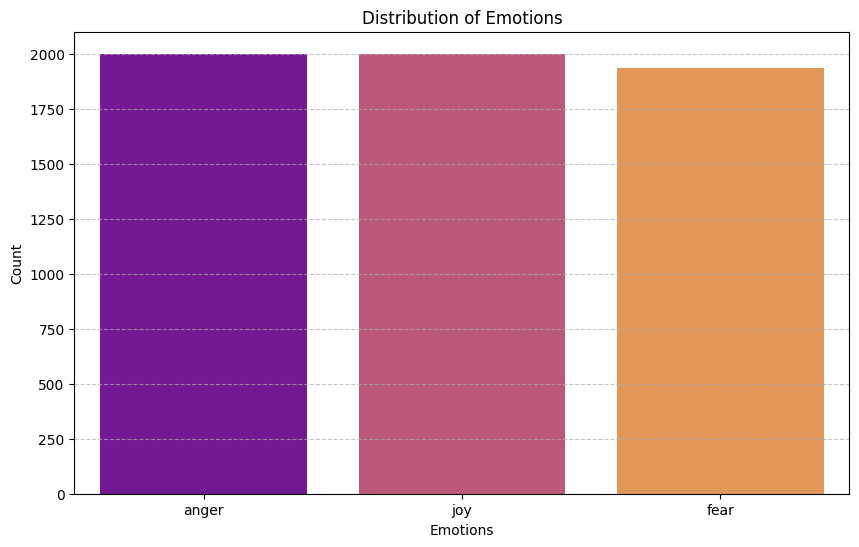

In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette="plasma")
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The dataset exhibits a balanced distribution among the target classes, which include 'anger', 'joy', and 'fear'.

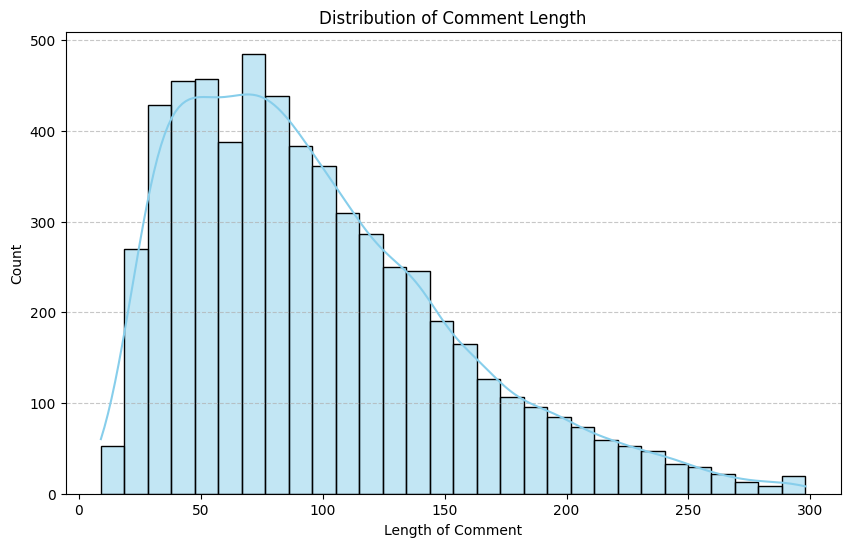

In [12]:
# comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_viz['Comment Length'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Comment Length')
plt.xlabel('Length of Comment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Comment length distribution skews towards the right, with the majority falling within the range of 30 to 130 characters. Outliers are observed in comment lengths exceeding 244 characters. Similarly, word count distribution is skewed to the right, with most falling between 5 to 30 words.

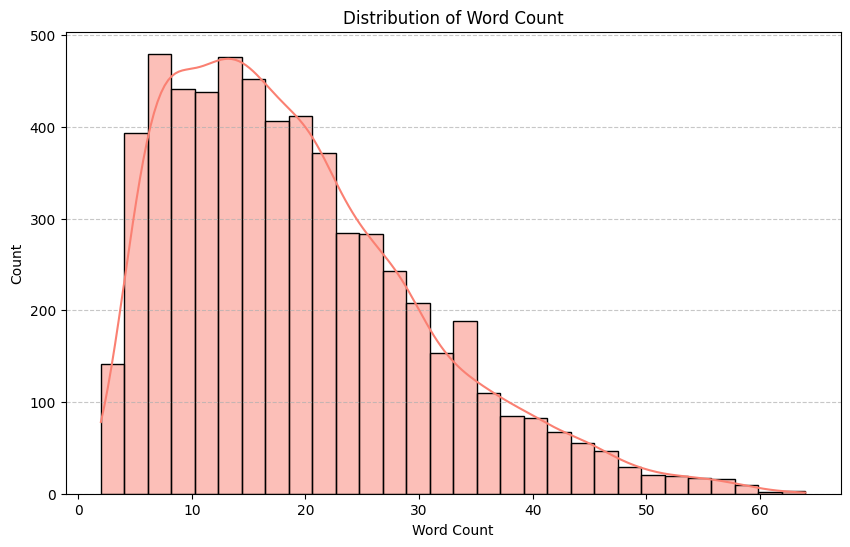

In [13]:
# word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_viz['Word Count'], bins=30, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

These findings suggest varying levels of expressiveness among individuals in the dataset. While the majority are concise, there are notable instances of individuals expressing themselves more openly and extensively.

In [ ]:
# saving for deployment
data_viz.to_csv('eda.csv', index= False)

### **Function**

Making some functions to call later
- function of stopwords
- function to preprocessing
- function to plotting the result
- function of evaluation report

In [14]:
# Add new stopwords as part of preprocess_text
stop_words_en = stopwords.words('english')
new_stop_words = [
    'im', 'feel', 'feeling', 'like', 'get',
    'ive', 'know', 'really', 'little', 'time',
    'id', 'make', 'people', 'want', 'thing'
]
stop_words_en.extend(new_stop_words)
stop_words_en = list(set(stop_words_en))

In [15]:
# preprocessing
def get_wordnet_pos_tag(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    lowercase_text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(lowercase_text)  # Tokenize text
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_en]  # Remove stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos_tag(token)) for token in filtered_tokens]  # Lemmatize tokens
    clean_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in lemmatized_tokens]  # Remove punctuation
    return ' '.join(clean_tokens)  # Join cleaned tokens back into a single string

In [16]:
# function for plotting result
def plot_result(result):
  result_df = pd.DataFrame(result.history)
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  sns.lineplot(data=result_df[['accuracy', 'val_accuracy']])
  plt.grid()
  plt.title('Accuracy vs Val-Accuracy')

  plt.subplot(1, 2, 2)
  sns.lineplot(data=result_df[['loss', 'val_loss']])
  plt.grid()
  plt.title('Loss vs Val-Loss')
  plt.show()

In [17]:
# function for evaluation report
def performance_check(model, X, y_ohe):
  display_labels =['fear', 'anger', 'joy']
  y_pred = model.predict(X)
  predictions = np.argmax(y_pred, axis=1)
  labels = np.argmax(y_ohe, axis=1)

  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  print(classification_report(labels, predictions, target_names=display_labels))

### **Text Preprocessing (EDA)**

In [18]:
data_viz.sample(10)['Comment']

3780    i look hot i get leers that make me feel like ...
5212    ill write a bunch youll respond and then ill b...
5740                                i keep feel irritated
5219      i feel like im a shy enormous pink flamingo man
2650                  i have been feeling restless lately
3994    a scene in a film in which one man repressed a...
3437               i feel damn agitated during the speech
1107    i didnt feel the cold up there because we had ...
72                                     i feel so tortured
2142    i had just eaten a particularly dreadful railw...
Name: Comment, dtype: object

In [19]:
# Calling the function that has been made
data_viz['Processed Comment'] = data_viz['Comment'].apply(preprocess_text)

In [20]:
data_viz[['Processed Comment', 'Emotion']].sample(10)

,Processed Comment,Emotion
389,rest yall appalled,anger
2857,thought scared somewhat trepidatious nervous sad,fear
3386,cold mostly arm torso,anger
2653,see unhealthy weight gained back pissed let cr...,anger
4263,fairly calm,joy
3890,quite cold actually,anger
2351,working one unsure completing,fear
1176,think lot fun meeting player expectation makin...,joy
1546,restless career,fear
3575,particular uncomfortable even asserting ever love,fear


### **Most Common Words**

In [21]:
# using counter to count the number of words
words = [word for text in data_viz['Processed Comment'] for word in text.split()]

word_freq = Counter(words) # count of each word

In [22]:
# respective emotions word count
emotion_word_freq= {}

for emote in data_viz['Emotion'].unique():
    words= [word for text in data_viz[data_viz['Emotion'] == emote]['Processed Comment'] for word in text.split()]
    emotion_word_freq[emote] = Counter(words)

### **Anger**

In [24]:
# Isolating anger emotion words
anger_word_freq = emotion_word_freq['anger']
print('Top 10 most frequent anger words:')
display(anger_word_freq.most_common(10))
print()
print('Top 10 least frequent anger words:')
display(anger_word_freq.most_common()[:-10-1:-1])

Top 10 most frequent anger words:


[('even', 87),
 ('way', 85),
 ('would', 84),
 ('one', 81),
 ('angry', 79),
 ('think', 74),
 ('thing', 73),
 ('day', 72),
 ('could', 72),
 ('bit', 70)]


Top 10 least frequent anger words:


[('center', 1),
 ('leading', 1),
 ('led', 1),
 ('cross', 1),
 ('binging', 1),
 ('stic', 1),
 ('confined', 1),
 ('bein', 1),
 ('runnin', 1),
 ('cola', 1)]

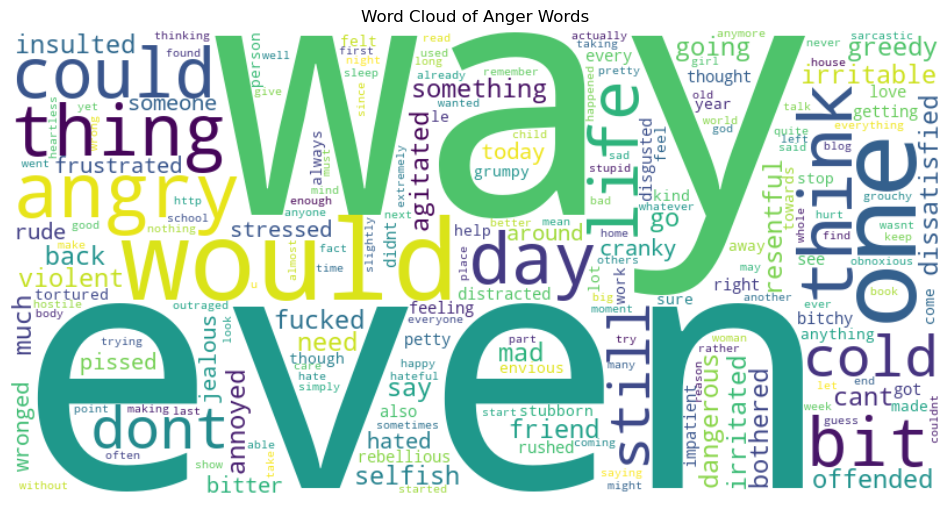

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(anger_word_freq)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Anger Words')
# Save the word cloud as a PNG file
plt.savefig("anger_wordcloud.png", bbox_inches='tight', pad_inches=0)
plt.show()

The Anger word cloud reveals prevalent expressions linked to feelings of anger, with notable words including "would," "even," "way," "think," and "angry." These terms are frequently used during episodes of anger, signifying the common language associated with this emotion. Notably, the presence of auxiliary verbs like "would" and "even" suggests a nuanced aspect, potentially indicating mood or tense in the context of anger. This analysis provides valuable insights into the linguistic patterns surrounding anger, shedding light on the vocabulary employed during moments of heightened emotional intensity.

### **Joy**

In [25]:
# isolating joy
joy_word_freq= emotion_word_freq['joy']
print('Top 10 most frequent joy words')
display(joy_word_freq.most_common(10))
print()
print('Top 10 lest frequent joy words')
display(joy_word_freq.most_common()[:-10-1:-1])

Top 10 most frequent joy words


[('day', 91),
 ('life', 76),
 ('good', 76),
 ('something', 76),
 ('one', 76),
 ('going', 72),
 ('way', 72),
 ('even', 71),
 ('much', 69),
 ('think', 67)]


Top 10 lest frequent joy words


[('intimated', 1),
 ('urgh', 1),
 ('spontaneous', 1),
 ('sachaying', 1),
 ('handbag', 1),
 ('ambition', 1),
 ('stasia', 1),
 ('coz', 1),
 ('anger', 1),
 ('amazingly', 1)]

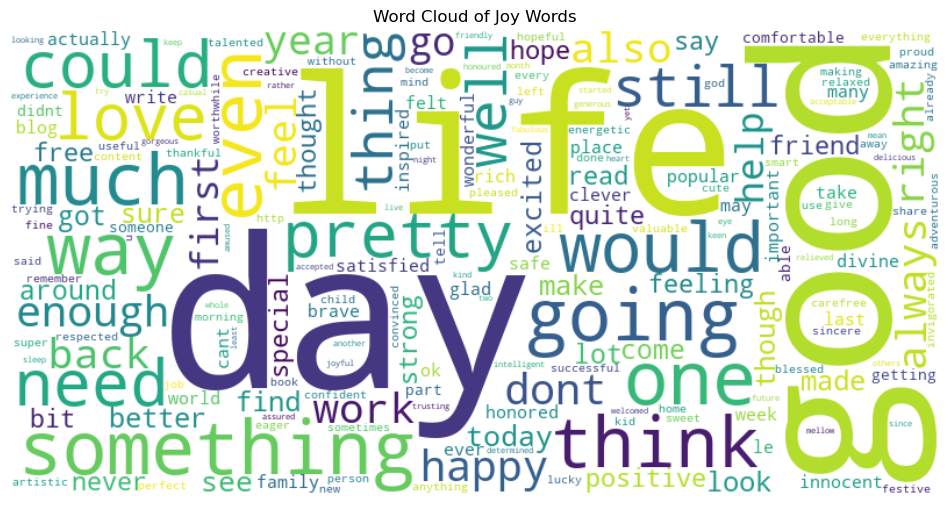

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(joy_word_freq)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Joy Words')
# Save the word cloud as a PNG file
plt.savefig("joy_wordcloud.png", bbox_inches='tight', pad_inches=0)
plt.show()

The Joy word cloud offers a condensed glimpse into the prevalent sentiments associated with joy. It showcases frequently used words like "life," "good," "day," "something," "going," and "well," illuminating the common vocabulary employed to articulate joyful experiences. This visualization effectively encapsulates the essence of joy by highlighting the recurring themes and expressions that resonate with individuals experiencing happiness and contentment.

### **Fear**

In [26]:
# isolating fear
fear_word_freq= emotion_word_freq['fear']
print('Top 10 most frequent fear words')
display(fear_word_freq.most_common(10))
print()
print('Top 10 lest frequent fear words')
display(fear_word_freq.most_common()[:-10-1:-1])

Top 10 most frequent fear words


[('bit', 118),
 ('still', 84),
 ('think', 79),
 ('strange', 78),
 ('nervous', 75),
 ('terrified', 74),
 ('going', 72),
 ('one', 71),
 ('would', 71),
 ('anxious', 71)]


Top 10 lest frequent fear words


[('planting', 1),
 ('clingy', 1),
 ('familiar', 1),
 ('account', 1),
 ('professional', 1),
 ('frequented', 1),
 ('website', 1),
 ('chase', 1),
 ('similarity', 1),
 ('lighten', 1)]

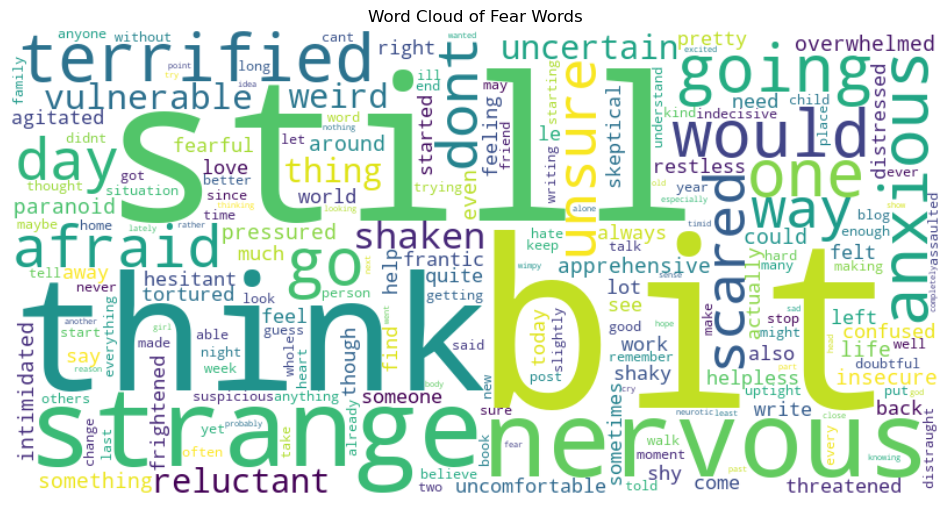

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(fear_word_freq)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Fear Words')
# Save the word cloud as a PNG file
plt.savefig("fear_wordcloud.png", bbox_inches='tight', pad_inches=0)
plt.show()

The Fear word cloud showcases prevalent words linked to feelings of fear, including "still," "bit," "strange," and "think." These terms frequently emerge when individuals express worry or anxiousness, reflecting the multifaceted nature of fear. In particular, fear of the unknown often triggers feelings of worry and anxiety, as individuals grapple with uncertainty and anticipation. However, fear encompasses a broad spectrum of emotions, ranging from a sense of unease to being scared or terrified, eliciting physical reactions like goosebumps. This analysis provides valuable insights into the diverse ways fear manifests, capturing both the cognitive and physiological aspects of this complex emotion.

The visualization provides insight into the dataset's emotions, along with comment length and word count distributions. These insights are vital for subsequent analysis and modeling. Additionally, the word clouds visually depict the most common words linked to each emotion, enhancing our understanding of the dataset.

## **Feature Engineering**

In [27]:
# Make a copy dataframe
df = data.copy()

### **Text Preprocessing**

In [28]:
# calling function
df['preprocessed_text'] = df['Comment'].apply(preprocess_text)

In [29]:
df.head(10)

,Comment,Emotion,preprocessed_text
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death reluctant drop
1,im so full of life i feel appalled,anger,full life appalled
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feeling think afraid accep...
3,ive been really angry with r and i feel like a...,joy,angry r idiot trusting first place
4,i feel suspicious if there is no one outside l...,fear,suspicious one outside rapture happened something
5,i feel jealous becasue i wanted that kind of l...,anger,jealous becasue wanted kind love true connecti...
6,when a friend of mine keeps telling me morbid ...,anger,friend mine keep telling morbid thing happened...
7,i finally fell asleep feeling angry useless an...,anger,finally fell asleep angry useless still full a...
8,i feel a bit annoyed and antsy in a good way,anger,bit annoyed antsy good way
9,i feel like i ve regained another vital part o...,joy,regained another vital part life living


### **Target Conversion**

In [30]:
# Display Target
df.Emotion.unique()

array(['fear', 'anger', 'joy'], dtype=object)

In [31]:
# Change Target into Number
df['label'] = df['Emotion'].replace({'fear' : 0, 'anger' : 1, 'joy' : 2})

In [32]:
# Check df with updated label
df.head()

,Comment,Emotion,preprocessed_text,label
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death reluctant drop,0
1,im so full of life i feel appalled,anger,full life appalled,1
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feeling think afraid accep...,0
3,ive been really angry with r and i feel like a...,joy,angry r idiot trusting first place,2
4,i feel suspicious if there is no one outside l...,fear,suspicious one outside rapture happened something,0


In [33]:
# Target distribution
df['label'].value_counts()

1    2000
2    2000
0    1937
Name: label, dtype: int64

### **Data Splitting**

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.preprocessed_text,
                                                    df.label,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.125,
                                                  random_state=42,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (4155,)
Val Size   :  (594,)
Test Size  :  (1188,)


In [35]:
# Change target to one hot encoder
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## **Model Building**

### **Text Vectorization**

In [36]:
# Get vocabularies
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<4155x6508 sparse matrix of type '<class 'numpy.int64'>'
	with 30432 stored elements in Compressed Sparse Row format>

In [37]:
# Finding the number of vocabs and max token length
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  6508
Maximum Sentence Length :  32 tokens


This description suggests a sparse matrix of dimensions 4,155 rows by 6,508 columns, where most elements are zero. Specifically, out of all possible elements in the matrix (4,155 x 6,508), only 30,432 are non-zero.

After tokenization, there are 6,508 unique words in the vocabulary, and the longest sentence contains 32 tokens (words).

In [38]:
# Define TextVectorization layer
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize=None,
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

# Adapt TextVectorization layer to training data
text_vectorization.adapt(X_train)

In [39]:
# Define the Embedding layer
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

## **LSTM**

In [40]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(LSTM(16))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 lstm (LSTM)                 (None, 16)                9280      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 842355 (3.21 MB)
Trainable params: 842355 (3.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I built a model using a three-layer LSTM network. First, turned text into numbers. Then, converted these numbers into simpler forms. After that, used a layer to find patterns in the text's sequence. Finally, i added a layer to make predictions. The model was set up to improve its guesses using an Adam optimizer, counting how often it's right or wrong. Then, next is train the model.

In [41]:
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
130/130 [==============================] - 7s 36ms/step - loss: 1.0832 - accuracy: 0.3516 - val_loss: 0.8017 - val_accuracy: 0.5993
Epoch 2/50
130/130 [==============================] - 4s 31ms/step - loss: 0.7060 - accuracy: 0.6188 - val_loss: 0.7651 - val_accuracy: 0.6044
Epoch 3/50
130/130 [==============================] - 4s 29ms/step - loss: 0.6069 - accuracy: 0.6479 - val_loss: 0.9892 - val_accuracy: 0.5758
Epoch 4/50
130/130 [==============================] - 4s 29ms/step - loss: 0.6626 - accuracy: 0.6428 - val_loss: 0.8380 - val_accuracy: 0.5875
Epoch 5/50
130/130 [==============================] - 4s 34ms/step - loss: 0.5675 - accuracy: 0.6522 - val_loss: 0.8573 - val_accuracy: 0.5976
Epoch 6/50
130/130 [==============================] - 4s 28ms/step - loss: 0.5029 - accuracy: 0.7617 - val_loss: 0.6826 - val_accuracy: 0.8131
Epoch 7/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2388 - accuracy: 0.9495 - val_loss: 0.7733 - val_accuracy: 0.7929

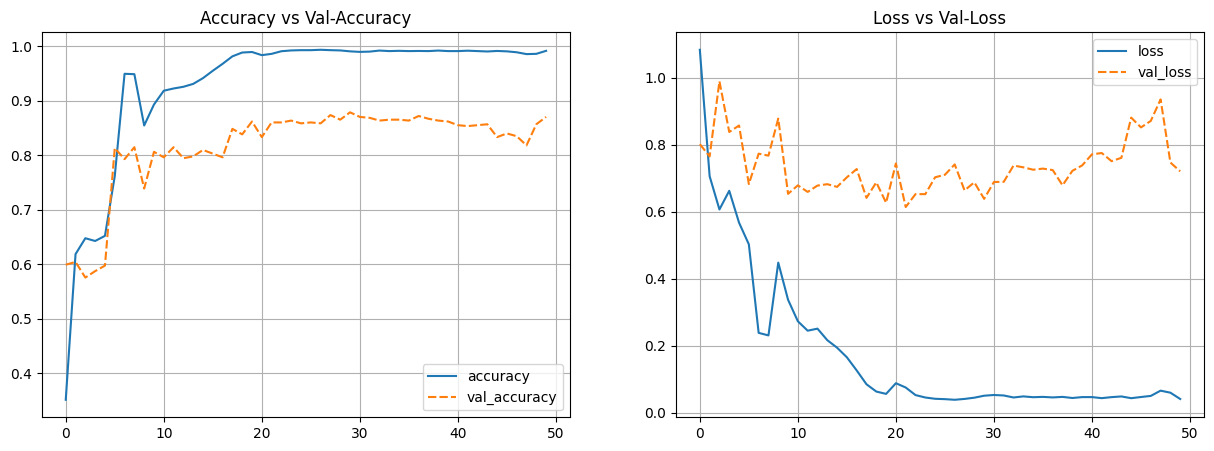

In [42]:
# plot result
plot_result(model_lstm_1_hist)

This model overfits by a lot as seen on the graph

## **Tuned Model 1**

**MODEL IMPROVEMENT**

In [46]:
from tensorflow.keras.layers import BatchNormalization

# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_tuned_1 = Sequential()
model_tuned_1.add(text_vectorization)
model_tuned_1.add(embedding)
model_tuned_1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  # Add dropout to LSTM layer
model_tuned_1.add(Dense(3, activation='softmax'))

# Build the model with a specific input shape
model_tuned_1.build(input_shape=(None,))

model_tuned_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_tuned_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 882627 (3.37 MB)
Trainable params: 882627 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I have designed a neural network architecture with several layers. Firstly, there's a text vectorization layer followed by an embedding layer, which is responsible for converting the text into numerical representations. Then, I added an LSTM layer with 64 units and applied dropout regularization with a dropout rate of 0.2 to prevent overfitting. Subsequently, a dense layer with softmax activation was added to produce the final classification output. Additionally, I included batch normalization to normalize the activations of the previous layer. Finally, the model was compiled using the Adam optimizer, categorical crossentropy loss function, and accuracy as the evaluation metric.

In [47]:
model_tuned_1_hist = model_tuned_1.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
130/130 [==============================] - 14s 79ms/step - loss: 0.4054 - accuracy: 0.8178 - val_loss: 0.7214 - val_accuracy: 0.8266
Epoch 2/50
130/130 [==============================] - 10s 76ms/step - loss: 0.0550 - accuracy: 0.9925 - val_loss: 0.8854 - val_accuracy: 0.8350
Epoch 3/50
130/130 [==============================] - 10s 76ms/step - loss: 0.1133 - accuracy: 0.9771 - val_loss: 0.8091 - val_accuracy: 0.8047
Epoch 4/50
130/130 [==============================] - 9s 67ms/step - loss: 0.0889 - accuracy: 0.9844 - val_loss: 0.8272 - val_accuracy: 0.8300
Epoch 5/50
130/130 [==============================] - 10s 77ms/step - loss: 0.0920 - accuracy: 0.9836 - val_loss: 0.7327 - val_accuracy: 0.8552
Epoch 6/50
130/130 [==============================] - 10s 76ms/step - loss: 0.1036 - accuracy: 0.9803 - val_loss: 0.8843 - val_accuracy: 0.8064
Epoch 7/50
130/130 [==============================] - 10s 77ms/step - loss: 0.2018 - accuracy: 0.9430 - val_loss: 1.0424 - val_accuracy: 

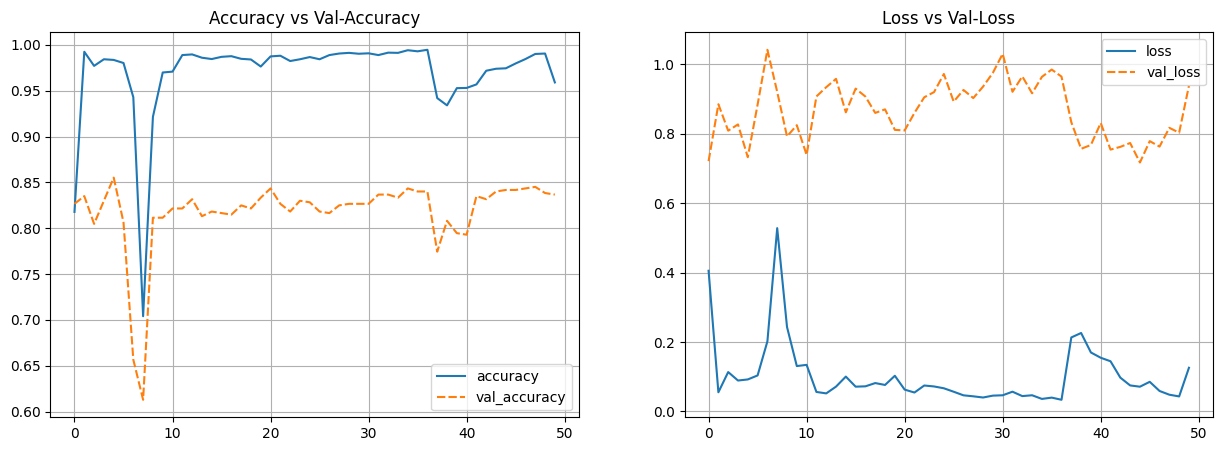

In [48]:
# plot result
plot_result(model_tuned_1_hist)

based on plot, we see that the model on tuned 1 still has overfit. So let's try using callbacks to reduce the overfit.

### **Using Callbacks and Regulations**

In [49]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model_checkpoint.keras', monitor='val_loss', save_best_only=True)
]

## **Tuned Model 2**

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_tuned_2 = Sequential()
model_tuned_2.add(text_vectorization)
model_tuned_2.add(embedding)
model_tuned_2.add(LSTM(16, dropout=0.5, recurrent_dropout=0.3,
                       kernel_regularizer=regularizers.l2(0.01),
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                       return_sequences=True))
model_tuned_2.add(BatchNormalization())
model_tuned_2.add(LSTM(8, dropout=0.5, recurrent_dropout=0.3,
                       kernel_regularizer=regularizers.l2(0.01),
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_tuned_2.add(BatchNormalization())
model_tuned_2.add(Dense(3, activation='softmax'))

# Build the model with a specific input shape
model_tuned_2.build(input_shape=(None,))

# Compile the model
model_tuned_2.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_tuned_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 lstm (LSTM)                 (None, 32, 16)            9280      
                                                                 
 batch_normalization (Batch  (None, 32, 16)            64        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 3

I've built a neural network with several layers. It starts with a text vectorization layer followed by an embedding layer to convert text into numbers. Then, there's an LSTM layer with 16 units, dropout, recurrent dropout, and L2 regularization. This layer sends sequences to the next one. After that, a batch normalization layer normalizes the data. Next, there's another LSTM layer with 8 units and similar settings. Another batch normalization layer follows, and finally, a dense layer with softmax activation is added for classification. The model is trained using the Adam optimizer with categorical crossentropy loss.

In [51]:
model_tuned_2_hist = model_tuned_2.fit(
    X_train, y_train_ohe, epochs=100, validation_data=(X_val, y_val_ohe),
    callbacks=callbacks1
    )

Epoch 1/100
130/130 [==============================] - 19s 93ms/step - loss: 1.9121 - accuracy: 0.4053 - val_loss: 1.3894 - val_accuracy: 0.5471
Epoch 2/100
130/130 [==============================] - 11s 87ms/step - loss: 0.6551 - accuracy: 0.9211 - val_loss: 0.7464 - val_accuracy: 0.8737
Epoch 3/100
130/130 [==============================] - 11s 85ms/step - loss: 0.3675 - accuracy: 0.9853 - val_loss: 0.7776 - val_accuracy: 0.8620
Epoch 4/100
130/130 [==============================] - 11s 85ms/step - loss: 0.2736 - accuracy: 0.9880 - val_loss: 0.7779 - val_accuracy: 0.8721
Epoch 5/100
130/130 [==============================] - 11s 86ms/step - loss: 0.2020 - accuracy: 0.9937 - val_loss: 0.7418 - val_accuracy: 0.8721
Epoch 6/100
130/130 [==============================] - 11s 82ms/step - loss: 0.1785 - accuracy: 0.9901 - val_loss: 1.0020 - val_accuracy: 0.8451
Epoch 7/100
130/130 [==============================] - 10s 79ms/step - loss: 0.1454 - accuracy: 0.9940 - val_loss: 0.9259 - val_ac

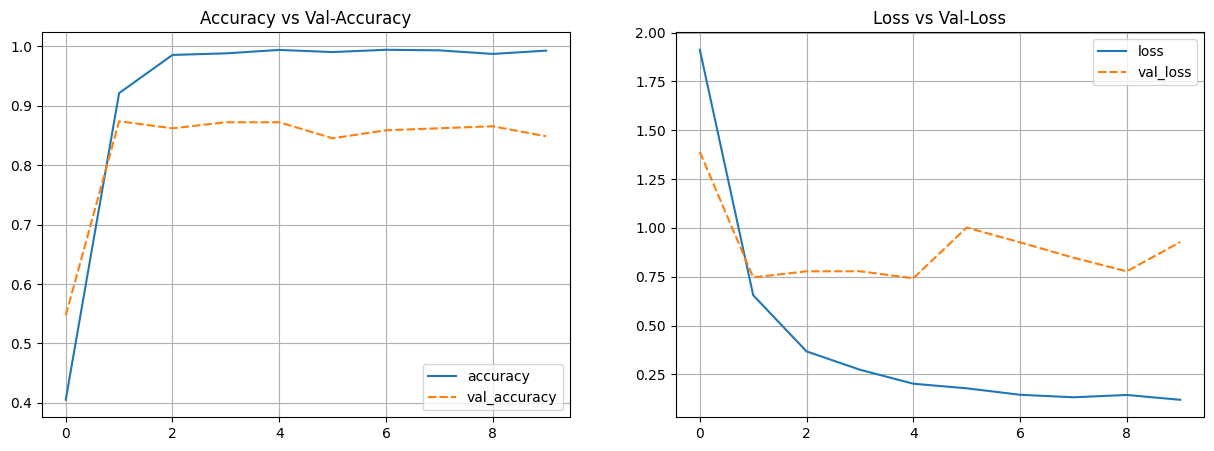

In [52]:
# plot result
plot_result(model_tuned_2_hist)

This model has smaller difference than the previous one but still overfits.

## **Tuned Model 3**

In [53]:
# Clear Session
tf.keras.backend.clear_session()
seed = 20
tf.random.set_seed(seed)

# Define the architecture
model_tuned_gru = Sequential()

model_tuned_gru.add(text_vectorization)
model_tuned_gru.add(embedding)
model_tuned_gru.add(Bidirectional(GRU(32, return_sequences=True,
                                      dropout=0.1, recurrent_dropout=0.3,
                                      kernel_regularizer=regularizers.l2(0.01))))
model_tuned_gru.add(Dropout(0.2))
model_tuned_gru.add(Bidirectional(GRU(32,
                                      dropout=0.1, recurrent_dropout=0.3,
                                      kernel_regularizer=regularizers.l2(0.01))))
model_tuned_gru.add(Dropout(0.2))
model_tuned_gru.add(Dense(3, activation='softmax'))

# Build the model with a specific input shape
model_tuned_gru.build(input_shape=(None,))

# Compile the model
model_tuned_gru.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Display model summary
model_tuned_gru.summary()

# Define reducelr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model_tuned_gru.fit(X_train, y_train_ohe, epochs=100, validation_data=(X_val, y_val_ohe),
                               callbacks=[callbacks1, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            31104     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                18816     
 onal)                                                           
                                                        

I've constructed a neural network architecture with a bidirectional GRU layer. Firstly, there's a text vectorization layer followed by an embedding layer. Then, I added a bidirectional GRU layer with 32 units, incorporating dropout of 0.1, recurrent dropout of 0.3, and L2 regularization with a coefficient of 0.01. This layer returns sequences to the subsequent layer. After that, a dropout layer with a dropout rate of 0.2 is added. Next, another bidirectional GRU layer with 32 units is added with similar dropout and regularization settings. Another dropout layer follows. Finally, a dense layer with softmax activation is added for classification output. The model is compiled using the Adam optimizer with categorical crossentropy loss. Additionally, a ReduceLROnPlateau callback is defined to reduce the learning rate during training.

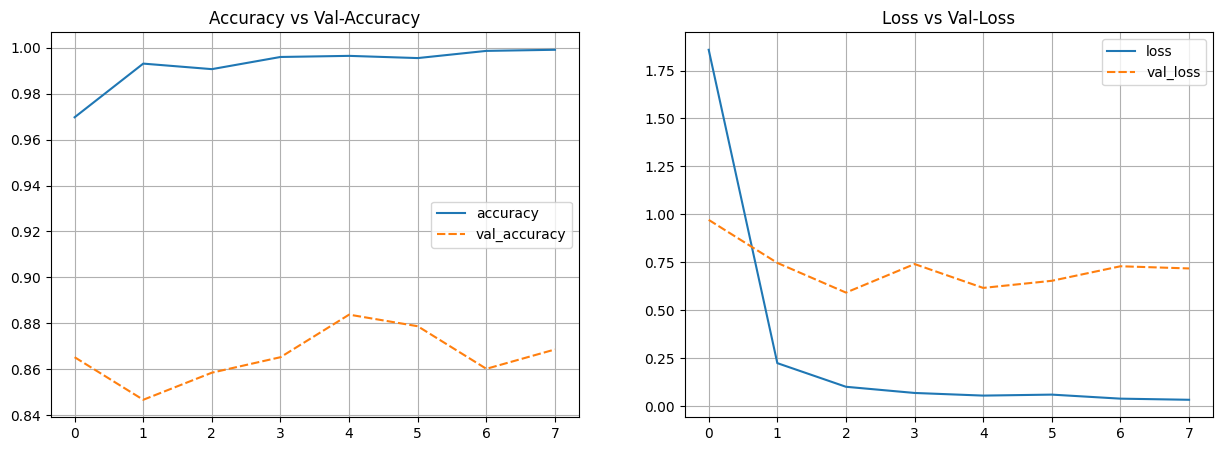

In [54]:
# plot result
plot_result(history)

this model has better than before, but in between loss and validation loss has underfit.

## **Tuned Model 4**

In [67]:
# model tuned 4
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_tuned_4 = Sequential()

model_tuned_4.add(text_vectorization)
model_tuned_4.add(embedding)
model_tuned_4.add(Bidirectional(LSTM(32, return_sequences=True,
                                   dropout=0.2, recurrent_dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned_4.add(Dropout(0.2))
model_tuned_4.add(Bidirectional(LSTM(16,
                                   dropout=0.2, recurrent_dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned_4.add(Dropout(0.2))
model_tuned_4.add(Dense(3, activation='softmax'))


model_tuned_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_tuned_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

I've configured a neural network architecture named model_tuned_4. It begins with a text vectorization layer, followed by an embedding layer. Next, I included two bidirectional LSTM layers. The first LSTM layer has 32 units, and the second one has 16 units. Both LSTM layers have dropout rates of 0.2 and recurrent dropout rates of 0.1. Glorot uniform initializer is used for weight initialization. Dropout layers with a dropout rate of 0.2 are added after each LSTM layer. Finally, a dense layer with softmax activation is added for classification output. The model is compiled using the Adam optimizer with categorical crossentropy loss.

In [68]:
model_tuned_hist = model_tuned_4.fit(
    X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe),
    callbacks=callbacks1
    )

Epoch 1/50
130/130 [==============================] - 40s 193ms/step - loss: 0.2647 - accuracy: 0.9430 - val_loss: 0.6492 - val_accuracy: 0.8620
Epoch 2/50
130/130 [==============================] - 24s 182ms/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 0.7961 - val_accuracy: 0.8653
Epoch 3/50
130/130 [==============================] - 31s 239ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 0.7185 - val_accuracy: 0.8636
Epoch 4/50
130/130 [==============================] - 25s 195ms/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 0.9077 - val_accuracy: 0.8586
Epoch 5/50
130/130 [==============================] - 24s 182ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.9635 - val_accuracy: 0.8603
Epoch 6/50
130/130 [==============================] - 23s 179ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 1.0369 - val_accuracy: 0.8535


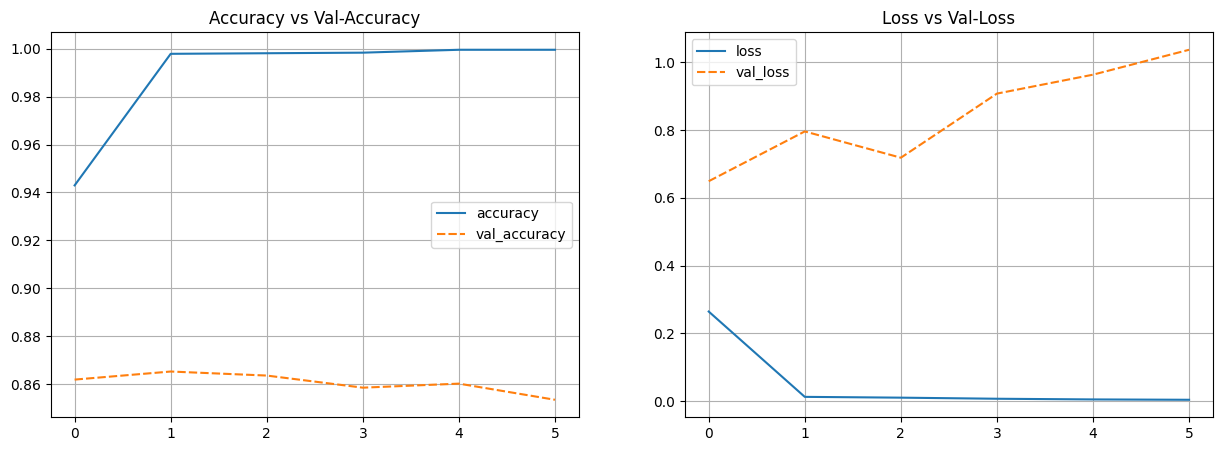

In [69]:
plot_result(model_tuned_hist)

Based on plot, i think this model better than all of the models that i made. But still the model has overfits

## **Model Comparing & Evaluation**

| Models         | Accuracy | Val Accuracy | Performance |
|----------------|----------|--------------|-------------|
| LSTM            | 99%    | 87%        | Long        |
| LSTM tuned 1   | 95%    |83%         | Longest     |
| LSTM tuned 2   | 99%   | 84%         | Long        |
| GRU tuned 3   | 99%    | 86%        | Long        |
| **LSTM tuned 4**   | **99%**    | **85%**      | **Long**  |

Model Evaluation ANN
Test - Set
38/38 [==============================] - 0s 10ms/step


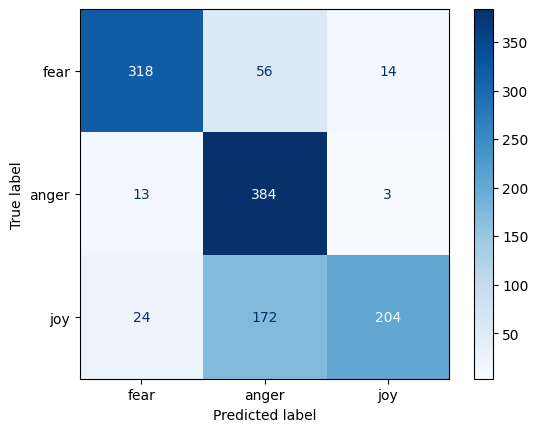

              precision    recall  f1-score   support

        fear       0.90      0.82      0.86       388
       anger       0.63      0.96      0.76       400
         joy       0.92      0.51      0.66       400

    accuracy                           0.76      1188
   macro avg       0.82      0.76      0.76      1188
weighted avg       0.81      0.76      0.76      1188

Model Evaluation ANN Improvement
Test - Set
38/38 [==============================] - 2s 47ms/step


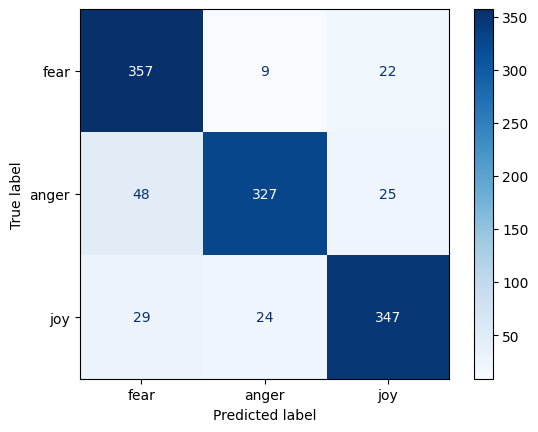

              precision    recall  f1-score   support

        fear       0.82      0.92      0.87       388
       anger       0.91      0.82      0.86       400
         joy       0.88      0.87      0.87       400

    accuracy                           0.87      1188
   macro avg       0.87      0.87      0.87      1188
weighted avg       0.87      0.87      0.87      1188



In [74]:
# Make predictions
# Model evaluation ANN
print('Model Evaluation ANN')
print('Test - Set')
performance_check(model_lstm_1, X_test, y_test_ohe)

# Model evaluation ANN Improvement
print('Model Evaluation ANN Improvement')
print('Test - Set')
performance_check(model_tuned_4, X_test, y_test_ohe)

The classification report and confusion matrix illustrate that the model performs well in predicting positive emotions overall, exhibiting high precision, recall, and F1-score values. However, it struggles with negative predictions, suggesting difficulty in identifying instances of negative emotions accurately. Despite this challenge, the F1-score remains relatively high, indicating a good balance between precision and recall. Specifically, the model faces challenges in distinguishing between joy and anger, possibly due to overlapping linguistic expressions between the two emotions.

In [ ]:
df[(df['Emotion'] == 'joy') | (df['Emotion'] == 'anger')][['Emotion','preprocessed_text']].sample(15)

,Emotion,preprocessed_text
253,joy,better menu tonight
873,joy,frame going properly keen plenty probably coul...
5229,joy,hadnt well week calgary added relaxation first...
5586,joy,tell first made think gorgeous guy ever seen l...
623,joy,peaceful made right decision
2272,joy,remember disappointed showing month actually l...
5376,joy,brave society accept u disabled amongst u dese...
5496,joy,trying positive positive
2304,joy,lot good day fabulous lot energy lately also b...
4779,joy,pretty spot instance guessing


In [ ]:
joy_dict = dict(joy_word_freq.most_common(30))
anger_dict = dict(anger_word_freq.most_common(30))

common_words = set(joy_dict.keys()) & set(anger_dict.keys())
common_words_counts = {word: (joy_dict[word], anger_dict[word]) for word in common_words}

print(' joy - anger')
display(common_words_counts)

 joy - anger


{'life': (76, 69),
 'go': (43, 53),
 'thing': (56, 73),
 'could': (61, 72),
 'day': (91, 72),
 'one': (76, 81),
 'something': (76, 60),
 'back': (50, 58),
 'even': (71, 87),
 'dont': (54, 66),
 'think': (67, 74),
 'would': (65, 84),
 'way': (72, 85),
 'need': (61, 58),
 'still': (60, 64)}

The analysis of the data reveals that certain words contribute to noise or insignificance, potentially leading to misclassifications. A recommendation for future improvement is to enhance the text processing phase. By reducing noise and focusing on more significant data, the model can achieve greater accuracy in its predictions.

#### **Model Saving**

In [76]:
# Save the model
dump(stop_words_en, 'stopword_list.joblib')
model_tuned_4.save('best_model.keras') # model tuned 4

The model that is saved is a model with LSTM (tuned). model saved successfully.

## **Conclusion**

The dataset is well-structured with balanced target classes. Exploratory Data Analysis reveals that most individuals are concise in expressing their feelings, with only a few providing detailed descriptions. Common words used to describe joyful experiences include 'life', 'good', 'day', 'something', 'going', and 'well'. Conversely, words commonly associated with anger include 'would', 'even', 'way', 'think', and 'angry'. Fear-related words such as 'still', 'bit', 'strange', and 'think' are also prevalent. The best-performing model utilizes an GRU network with 99% accuracy and 85% validation accuracy. However, there is still room for improvement, particularly in reducing noise through preprocessing techniques like adding more stopwords. Additionally, incorporating data on a wider range of emotions would enhance the model's ability to classify diverse emotional states.